<h1> Импорт </h1>

Импортируем необходимые библиотеки и инструменты.

In [1]:
import ast
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from random import randint, random
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from tensorflow import keras
from tqdm import tqdm

Загрузим данные из онлайн-кинотеатра Кион.

In [2]:
users_df = pd.read_csv("Dataset/users.csv")
items_df = pd.read_csv("Dataset/items.csv")
interactions_df = pd.read_csv("Dataset/interactions_df.csv")

<h1> Подготовка данных </h1>

<h2> EDA (Разведочный анализ данных) </h2> Для начала, посмотрим на наши данные.

In [3]:
users_df.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [4]:
items_df.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [5]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


<h1> Готовим фичи пользователей </h1>

Посмотрим, какие фичи в датасете фильмов являются категориальными и закодируем их с помощью one-hot encoding.

Данный код является частью подготовки данных для обучения модели машинного обучения. В данном случае мы готовим признаки пользователей (users features), которые будут использоваться для рекомендации фильмов на основе поведения пользователя.

Код выполняет следующие действия:

- Определяется список категориальных признаков пользователей: "age", "income", "sex", "kids_flg".
- Для каждого категориального признака создается датафрейм, содержащий one-hot encoding для этого признака.
- Создается новый датафрейм, содержащий только идентификаторы пользователей и все one-hot encoding признаки, которые были созданы на предыдущем шаге. Для этого используется метод pd.concat(), который объединяет датафреймы по оси 1 (столбцы).
- В итоге получается новый датафрейм users_ohe_df, содержащий one-hot encoding признаки пользователей.

Данный подход к обработке категориальных признаков (one-hot encoding) позволяет использовать эти признаки в качестве входных данных для модели машинного обучения. Он применяется для преобразования категориальных признаков в бинарные, что позволяет использовать их в алгоритмах машинного обучения, которые работают только с числовыми данными.

In [6]:
user_cat_feats = ["age", "income", "sex", "kids_flg"]

# из исходного датафрейма оставим только item_id - этот признак нам понадобится позже
# для того, чтобы маппить айтемы из датафрейма с фильмами с айтемами 
# из датафрейма с взаимодействиями
users_ohe_df = users_df.user_id
for feat in user_cat_feats:
  # получаем датафрейм с one-hot encoding для каждой категориальной фичи
  ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
  # конкатенируем ohe-hot датафрейм с датафреймом, 
  # который мы получили на предыдущем шаге
  users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()


,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,sex_Ж,sex_М,kids_flg_0,kids_flg_1
0,973171,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,962099,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
2,1047345,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
3,721985,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
4,704055,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0


<h1> Готовим фичи айтемов </h1>
Кодируем их точно так же - one-hot'ом.

In [7]:
item_cat_feats = ['content_type', 'release_year',
                  'for_kids', 'age_rating', 
                  'studios', 'countries', 'directors']

items_ohe_df = items_df.item_id

for feat in item_cat_feats:
  ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
  items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1) 

items_ohe_df.head()

,item_id,content_type_film,content_type_series,release_year_1897.0,release_year_1916.0,release_year_1917.0,release_year_1918.0,release_year_1920.0,release_year_1921.0,release_year_1922.0,...,directors_Яннике Систад Якобсен,directors_Янус Мец,directors_Ярив Хоровиц,directors_Ярон Зильберман,directors_Ярополк Лапшин,directors_Ярослав Лупий,"directors_Ярроу Чейни, Скотт Моужер",directors_Ясина Сезар,directors_Ясуоми Умэцу,directors_сения Завьялова
0,10711,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2508,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10716,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7868,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16268,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1> Собираем матрицу взаимодействий </h1>

Этот код отвечает за фильтрацию датасета взаимодействий между пользователями и фильмами. В датасете могут быть записи, которые не нужны для анализа, например, записи о малоактивных пользователях, непопулярных фильмах или событиях, которые не имеют качественного взаимодействия.

Сначала фильтруются записи о событиях взаимодействия, в которых пользователь посмотрел фильм менее, чем на 35% (то есть, если фильм был запущен, но сразу же закрыт, то это не считается за реальное взаимодействие).

Затем фильтруются малоактивные пользователи и непопулярные фильмы, оставляя только тех пользователей и фильмы, которые посмотрели/были просмотрены больше 10 раз.

Далее, чтобы избежать проблемы, когда некоторые айтемы/юзеры есть в датасете взаимодействий, но отсутствуют в датасетах айтемов/юзеров или наоборот, находятся id айтемов и id юзеров, которые есть во всех датасетах и оставляются только они в датасете взаимодействий, а также в датасетах айтемов/юзеров.

In [8]:
interactions_df.item_id.value_counts()

10440    202457
15297    193123
9728     132865
13865    122119
4151      91167
          ...  
8076          1
8954          1
15664         1
818           1
10542         1
Name: item_id, Length: 15706, dtype: int64

In [9]:
interactions_df.user_id.value_counts()

416206     1341
1010539     764
555233      685
11526       676
409259      625
           ... 
45493         1
615194        1
96848         1
425823        1
697262        1
Name: user_id, Length: 962179, dtype: int64

In [10]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

# отфильтруем все события взаимодействий, в которых пользователь посмотрел
# фильм менее чем на 35 процентов
interactions_df = interactions_df[interactions_df.watched_pct > 35]

# соберем всех пользователей, которые посмотрели 
# больше 10 фильмов
valid_users = []

c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
  if entries > 10:
    valid_users.append(user_id)

# и соберем все фильмы, которые посмотрели больше 10 пользователей
valid_items = []

c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
  if entries > 10:
    valid_items.append(item_id)

# отбросим непопулярные фильмы и неактивных юзеров
interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 962179
N items before: 15706

N users after: 54213
N items after: 6140


После фильтрации может получиться так, что некоторые айтемы/юзеры есть в датасете взаимодействий, но при этом они отсутствуют в датасетах айтемов/юзеров или наоборот. Поэтому найдем id айтемов и id юзеров, которые есть во всех датасетах и оставим только их.

In [11]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_ohe_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_ohe_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_ohe_df = items_ohe_df[items_ohe_df.item_id.isin(common_items)]
users_ohe_df = users_ohe_df[users_ohe_df.user_id.isin(common_users)]

44959
6140


Соберем взаимодействия в матрицу user*item так, чтобы в строках этой матрицы были user_id, в столбцах - item_id, а на пересечениях строк и столбцов - единица, если пользователь взаимодействовал с айтемом и ноль, если нет.

Такую матрицу удобно собирать в numpy array, однако нужно помнить, что numpy array индексируется порядковыми индексами, а нам же удобнее использовать item_id и user_id.

Создадим некие внутренние индексы для user_id и item_id - uid и iid. Для этого просто соберем все user_id и item_id и пронумеруем их по порядку.

In [12]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

print(sorted(interactions_df.iid.unique())[:5])
print(sorted(interactions_df.uid.unique())[:5])
interactions_df.head()

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


,user_id,item_id,last_watch_dt,total_dur,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72.0,7234,3500
1,699317,1659,2021-05-29,8317,100.0,28657,594
14,5324,8437,2021-04-18,6598,92.0,208,3084
18,927973,9617,2021-06-19,8422,100.0,37990,3536
20,896751,8081,2021-05-17,6358,100.0,36735,2953


Наконец соберем и отнормируем матрицу взаимодействий:

In [13]:
interactions_vec = np.zeros((interactions_df.uid.nunique(), 
                             interactions_df.iid.nunique())) 

for user_id, item_id in zip(interactions_df.uid, interactions_df.iid):
    interactions_vec[user_id, item_id] += 1


res = interactions_vec.sum(axis=1)
for i in range(len(interactions_vec)):
    interactions_vec[i] /= res[i]

Для того, чтобы можно было удобно превратить iid/uid в item_id/user_id и наоборот соберем словари

{iid: item_id}, {uid: user_id} и {item_id: iid}, {user_id: uid}.

In [14]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

И проиндексируем датасеты users_ohe_df и items_ohe_df по внутренним айди:

In [15]:
items_ohe_df["iid"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_iid.get(x))
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_uid.get(x))
users_ohe_df = users_ohe_df.set_index("uid")

<h2> DSSM starter's pack </h2>

Для того, чтобы собрать нейронную сеть, необходимо выполнить следующие пункты.

1. реализовать функцию потерь
2. реализовать генератор
3. понимать архитектуру модели

Начнем с функции потерь:

<h2> Triplet loss </h2>

Будем использовать triplet loss. Его схема:
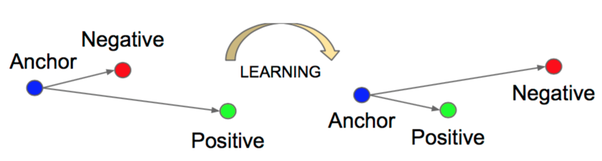

Возьмем вектор юзера (anchor) и векторы двух айтемов - "хорошего" и "плохого" (positive и negative). Хороший айтем - это тот, который пользователь уже посмотрел, а в качестве плохого возьмем любой случайный айтем из датасета. Затем посчитаем расстояния:
1. между вектором юзера и вектором "хорошего" айтема
2. между вектором юзера и вектором "плохого" айтема

Значением функции потерь будет разность между первым и вторым расстоянием.

In [16]:
def triplet_loss(y_true, y_pred, n_dims=128, alpha=0.4):
    # будем ожидать, что на вход функции прилетит три сконкатенированных 
    # вектора - вектор юзера и два вектора айтема
    anchor = y_pred[:, 0:n_dims]
    positive = y_pred[:, n_dims:n_dims*2]
    negative = y_pred[:, n_dims*2:n_dims*3]

    # считаем расстояния от вектора юзера до вектора хорошего айтема
    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    # и до плохого
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # считаем лосс
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0) # возвращаем ноль, если лосс отрицательный
 
    return loss


Параметр n_dims - это размерность внутреннего пространства модели

alpha это гиперпараметр. Если бы его не было, то basic_loss обращался бы в ноль, когда neg_dist = pos_dist и обучения бы на этом примере не происходило.

<h2> Генератор и семплирование </h2>

Сделаем простой генератор. Он будет брать рандромного юзера, и два разных айтема - хороший пример и плохой:

Хорошим примером будет тот айтем, который был взят из датасета взаимодействий в соответствии с распределением просмотренных айтемов для этого юзера;

а плохим айтемом будет просто любой другой случайный айтем.

In [17]:
def generator(items, users, interactions, batch_size=1024):
    while True:
        uid_meta = []
        uid_interaction = []
        pos = []
        neg = []
        for _ in range(batch_size):
            # берем рандомный uid
            uid_i = randint(0, interactions.shape[0]-1)
            # id хорошего айтема
            pos_i = np.random.choice(range(interactions.shape[1]), p=interactions[uid_i])
            # id плохого айтема
            neg_i = np.random.choice(range(interactions.shape[1]))
            # фичи юзера
            uid_meta.append(users.iloc[uid_i])
            # вектор айтемов, с которыми юзер взаимодействовал
            uid_interaction.append(interactions_vec[uid_i])
            # фичи хорошего айтема
            pos.append(items.iloc[pos_i])
            # фичи плохого айтема
            neg.append(items.iloc[neg_i])
            
        yield [np.array(uid_meta), np.array(uid_interaction), np.array(pos), np.array(neg)], [np.array(uid_meta), np.array(uid_interaction)]


посмотрим, что получается

In [18]:
# инициализируем генератор
gen = generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                users=users_ohe_df.drop(["user_id"], axis=1), 
                interactions=interactions_vec)

ret = next(gen)


print(f"вектор фичей юзера: {ret[0][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[0][1].shape}")
print(f"вектор 'хорошего' айтема: {ret[0][2].shape}")
print(f"вектор 'плохого' айтема: {ret[0][3].shape}")
print()
print(f"вектор фичей юзера: {ret[1][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[1][1].shape}")

вектор фичей юзера: (1024, 16)
вектор взаимодействий юзера с айтемами: (1024, 6136)
вектор 'хорошего' айтема: (1024, 8813)
вектор 'плохого' айтема: (1024, 8813)

вектор фичей юзера: (1024, 16)
вектор взаимодействий юзера с айтемами: (1024, 6136)


<h2> Собираем модель </h2>

Для того, чтобы обучить модель используя триплет лосс, нам нужно получить три вектора - вектор юзера, вектор "хорошего" айтема и вектор "плохого" айтема. Для этого нам нужно две модели ("хороший" и "плохой" айтем будут семплироваться одной и той же моделью).

Модель юзера будет иметь два входа:

вход для фичей юзера (фичи из users_ohe_df)
вход для вектора айтемов, которые посмотрел юзер (строка interactions_vec, которая соответствует uid конкретного юзера)

Выход модели юзера будет размерностью N_FACTORS.

У модели айтема будет один вход для фичей айтема (из items_ohe_df) и один выход также размерностью N_FACTORS.

Общая архитектура будет вот такой:

- есть модель юзера и модель айтема
- обе модели семплируют юзер и айтем-фичи во внутреннее пространство размерностью N_FACTORS
- модель айтема семплирует два айтема - "хороший" и "плохой"
- в итоге получается три вектора размерностью N_FACTORS (вектор юзера, вектор "хорошего" айтема и вектор "плохого" айтема)
- затем полученные векторы конкатенируются, по ним считается triplet loss

Для того, чтобы собрать модель, помимо размерности внутреннего пространства, нам нужно знать еще размерность вектора юзера и вектора айтема. Зададим их сразу.

In [19]:
N_FACTORS = 128

# в датасетах есть столбец user_id/item_id, помним, что он не является фичей для обучения!
ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], ) 
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (8813,)
USER_META_MODEL_SHAPE: (16,)
USER_INTERACTION_MODEL_SHAPE: (6136,)


In [20]:
def item_model(n_factors=N_FACTORS):
    # входной слой
    inp = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
    
    # полносвязный слой
    layer_1 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                               kernel_regularizer=keras.regularizers.l2(1e-6),
                               activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp)

    # делаем residual connection - складываем два слоя, 
    # чтобы градиенты не затухали во время обучения
    layer_2 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1)
    
    add = keras.layers.Add()([layer_1, layer_2])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(add)
    
    return keras.models.Model(inp, out)


def user_model(n_factors=N_FACTORS):
    # входной слой для вектора фичей юзера (из users_ohe_df)
    inp_meta = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
    # входной слой для вектора просмотров (из iteractions_vec)
    inp_interaction = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

    # полносвязный слой
    layer_1_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_meta)

    layer_1_interaction = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_interaction)

    # делаем residual connection - складываем два слоя,
    # чтобы градиенты не затухали во время обучения
    layer_2_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1_meta)
    

    add = keras.layers.Add()([layer_1_meta, layer_2_meta])
    
    # конкатенируем вектор фичей с вектором просмотров
    concat_meta_interaction = keras.layers.Concatenate()([add, layer_1_interaction])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(concat_meta_interaction)
    
    return keras.models.Model([inp_meta, inp_interaction], out)

# инициализируем модели юзера и айтема
i2v = item_model()
u2v = user_model()

# вход для вектора фичей юзера (из users_ohe_df)
ancor_meta_in = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
# вход для вектора просмотра юзера (из interactions_vec)
ancor_interaction_in = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

# вход для вектора "хорошего" айтема
pos_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
# вход для вектора "плохого" айтема
neg_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

# получаем вектор юзера
ancor = u2v([ancor_meta_in, ancor_interaction_in])
# получаем вектор "хорошего" айтема
pos = i2v(pos_in)
# получаем вектор "плохого" айтема
neg = i2v(neg_in)

# конкатенируем полученные векторы
res = keras.layers.Concatenate(name="concat_ancor_pos_neg")([ancor, pos, neg])

# собираем модель
model = keras.models.Model([ancor_meta_in, ancor_interaction_in, pos_in, neg_in], res)

Определяем традиционные коллбэки для обучения.
Коллбэк (callback) - это функция в фреймворке TensorFlow, которая может быть вызвана автоматически во время обучения модели в определенных точках, например, в конце каждой эпохи.

В данном случае в коде используются три коллбэка, каждый из которых выполняет определенную функцию:

- TensorBoard - записывает данные о процессе обучения в формате, который позволяет визуализировать эти данные в инструменте TensorBoard;
- ReduceLROnPlateau - уменьшает скорость обучения (learning rate), если функция потерь (loss) не уменьшается в течение нескольких эпох подряд;
- ModelCheckpoint - сохраняет модель после каждой эпохи, если функция потерь уменьшилась. Это позволяет сохранять прогресс обучения и восстанавливать модель в случае сбоев.

В целом, использование коллбэков помогает более эффективно контролировать и настраивать процесс обучения, повышает качество модели и уменьшает риск потери результатов обучения в случае сбоев.

In [21]:
model_name = 'recsys_resnet_linear'

# логируем процесс обучения в тензорборд
t_board = keras.callbacks.TensorBoard(log_dir=f'runs/{model_name}')

# уменьшаем learning_rate, если лосс долго не уменьшается (в течение двух эпох)
decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.8, verbose=1)

# сохраняем модель после каждой эпохи, если лосс уменьшился
check = keras.callbacks.ModelCheckpoint(filepath=model_name + '/epoch{epoch}-{loss:.2f}.h5', monitor="loss")

Adam - это оптимизатор, который обеспечивает быстрое и стабильное обучение глубоких моделей, позволяя модели автоматически адаптировать скорость обучения для каждого веса в зависимости от его исторического поведения.

In [22]:
# компилируем модель, используем оптимайзер Adam и triplet loss
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss=triplet_loss, optimizer=opt)

Этот фрагмент кода запускает процесс обучения модели с использованием созданного генератора данных. В качестве входных данных генератор получает три датафрейма: items_ohe_df, users_ohe_df и interactions_vec. Столбцы item_id и user_id из этих датафреймов не используются в обучении и поэтому отбрасываются с помощью метода drop(["item_id"], axis=1) и drop(["user_id"], axis=1).

В параметрах метода fit() задаются следующие аргументы:

- generator - генератор, созданный ранее для обучения модели.
- steps_per_epoch - количество шагов обучения на каждой эпохе. В данном случае используется значение 100.
- epochs - количество эпох обучения. В данном случае используется значение 30.
- initial_epoch - номер первой эпохи. В данном случае используется значение 0, так как мы начинаем обучение с самого начала.
- callbacks - список коллбэков, которые будут запущены во время обучения. В данном случае используются три коллбэка: decay для уменьшения learning rate, t_board для логирования процесса обучения в TensorBoard и check для сохранения модели после каждой эпохи, если лосс уменьшился.

In [23]:
# начинаем обучение, не забывая дропнуть столбцы item_id и user_id 
# из датафреймов при инициализации генератора.

# batch_size можно (и лучше) поставить побольше ( если ресурсы позволяют )

model.fit(generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                    users=users_ohe_df.drop(["user_id"], axis=1), 
                    interactions=interactions_vec,
                    batch_size=64),
          steps_per_epoch=100, 
          epochs=30, 
          initial_epoch=0,
          callbacks=[decay, t_board, check]
)

Epoch 1/30
100/100 [==============================] - 14s 122ms/step - loss: 0.3123 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 11s 115ms/step - loss: 0.2327 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 13s 128ms/step - loss: 0.2106 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 11s 115ms/step - loss: 0.1943 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 12s 117ms/step - loss: 0.1861 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 13s 134ms/step - loss: 0.1762 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 13s 131ms/step - loss: 0.1743 - lr: 0.0010
Epoch 8/30
100/100 [==============================] - 11s 110ms/step - loss: 0.1672 - lr: 0.0010
Epoch 9/30
100/100 [==============================] - 11s 107ms/step - loss: 0.1627 - lr: 0.0010
Epoch 10/30
100/100 [==============================] - 11s 113ms/step - loss: 0.1583 - lr: 0.0010
Epoch 11/30
100/100 [========

<h2> Inference </h2>

Данные подготовлены, собрана модель по архитектуре DSSM и она обучена. Теперь возьмем случайного юзера и случайный айтем. Как понять, насколько этот айтем релевантен юзеру?

Нужно:

- получить вектор айтема;
- получить вектор юзера;
- посчитать расстояние между ними.

Это расстояние и есть мера релевантности.

In [87]:

# берем рандомного юзера
rand_uid = np.random.choice(list(users_ohe_df.index))

# получаем фичи юзера и вектор его просмотров айтемов
user_meta_feats = users_ohe_df.drop(["user_id"], axis=1).iloc[rand_uid]
user_interaction_vec = interactions_vec[rand_uid]

# берем рандомный айтем
rand_iid = np.random.choice(list(items_ohe_df.index))
# получаем фичи айтема
item_feats = items_ohe_df.drop(["item_id"], axis=1).loc[rand_iid]

# получаем вектор юзера
user_vec = u2v.predict([np.array(user_meta_feats).reshape(1, -1), 
                        np.array(user_interaction_vec).reshape(1, -1)])

# и вектор айтема
item_vec = i2v.predict(np.array(item_feats).reshape(1, -1))

# считаем расстояние между вектором юзера и вектором айтема
from sklearn.metrics.pairwise import euclidean_distances as ED

ED(user_vec, item_vec)

1/1 [==============================] - 0s 15ms/step


array([[1.8634698]], dtype=float32)

Что дальше? Как понять, 1.86 это релевантно или нет? Очень просто: возьмем все айтемы, которые у нас есть, получим векторы для всех из них, а потом посчитаем расстояния от вектора юзера до векторов всех айтемов:

In [88]:
# получаем фичи всех айтемов
items_feats = items_ohe_df.drop(["item_id"], axis=1).to_numpy()
# получаем векторы всех айтемов
items_vecs = i2v.predict(items_feats)

# считаем расстояния
dists = ED(user_vec, items_vecs)

192/192 [==============================] - 0s 2ms/step


Итак, в этом коде мы хотим оценить, насколько релевантен случайно выбранный айтем случайно выбранному пользователю. Для этого мы:

1. Выбираем случайного пользователя из данных.
2. Получаем фичи пользователя и вектор его просмотров айтемов.
3. Выбираем случайный айтем из данных.
4. Получаем фичи айтема.
5. Получаем вектор пользователя с помощью обученной модели (u2v).
6. Получаем вектор айтема с помощью обученной модели (i2v).
7. Считаем расстояние между вектором пользователя и вектором айтема с помощью функции euclidean_distances из библиотеки scikit-learn.
8. Для всех айтемов в данных мы повторяем пункты 4-6, получая векторы для всех айтемов, а затем считаем расстояния между вектором пользователя и векторами всех айтемов.

Таким образом, мы получаем меру релевантности случайно выбранного айтема для случайно выбранного пользователя в виде расстояния между их векторами. Если расстояние между векторами маленькое, то мы можем считать, что айтем более релевантен пользователю, и наоборот, если расстояние большое, то мы можем считать, что айтем менее релевантен.

Теперь мы знаем расстояния от юзера до всех айтемов. Значит, мы легко сможем найти для юзера например топ 10 релевантных айтемов:

In [89]:
top10_iids = np.argsort(dists, axis=1)[0][:10]
top10_iids

array([2062,  152, 5759, 1859, 4120, 5113, 3573,  792, 4679, 1006],
      dtype=int64)

Осталось конвертировать внутренние iid в item_id:

In [90]:
top10_item_ids = [iid_to_item_id[iid] for iid in top10_iids]
top10_item_ids

[5693, 429, 15464, 5087, 11194, 13865, 9728, 2237, 12676, 2852]

In [91]:
recommended_titles = items_df.loc[items_df.item_id.isin(top10_item_ids)].title
recommended_titles

2024                       Анон
4270        Алита: Боевой ангел
4688       Великий уравнитель 2
4955                    Апгрейд
6346          Гнев человеческий
6501                   Девятаев
13596          Номер семнадцать
14875               Сквозь снег
14947    Лесбиянки со страпоном
15922                     Код 8
Name: title, dtype: object

In [92]:
iids_viewed = np.where(interactions_vec[rand_uid] > 0)
viewed_titles = items_df.iloc[iids_viewed].title
viewed_titles

482                                         Суфлер
792                        Доживем до понедельника
1164                               [4k] Кыргызстан
2034                           Любовное настроение
2277                Особо опасна (жестовым языком)
3211                  Горец 3: Последнее измерение
3573          Афера доктора Нока (жестовым языком)
3585                                   Тёмные воды
3634                                 Экспроприатор
4000                               Проклятый дом 4
4781                                        Бункер
5158                            Вот моя деревня...
5477                                Первоклассница
5501    Рапунцель: Новая история (короткометражки)
5842                Max Steel: Максимальный Морфос
Name: title, dtype: object